In [1]:
from chinna_grad.engine import Node
from chinna_grad.neural_net import MLP
import matplotlib.pyplot as plt

In [2]:

# Visualize the connections
from graphviz import Digraph as dir_graph

def trace(result):
    # Use DFS to build a set of all nodes and edges starting from the final result node
    nodes = set()
    edges = set()
    def build(node):
        if (node not in nodes):
            nodes.add(node)
            for child in (node._prev):
                edges.add((child, node))
                build(child)
    build(result)
    return (nodes, edges)

def draw_graph(result):
    graph = dir_graph(format = 'svg', graph_attr = {'rankdir': "LR"})  # Draw the graph from left to right
    nodes, edges = trace(result)
    for node in nodes:
        uniqueName = str(id(node))
        # For every node, create a rectangle
        graph.node(name = uniqueName, label = "{%s | data: %.3f | gradient: %.3f}" % (node.name, node.data, node.grad), shape = "record")

        # For non-input nodes, create an operation node behind it
        if node._op:
            opNodeName = uniqueName + node._op
            graph.node(name = opNodeName, label = node._op)
            graph.edge(opNodeName, str(id(node)))
    
    for node1, node2 in edges:
        graph.edge(str(id(node1)), str(id(node2)) + node2._op)
    
    return graph

In [ ]:
a = Node(3.0)
b = Node(-3.0)
c = a * b
d = Node(10.0)
e  = c  + d


#-------Trying out tanh implementation from scratch-----
# f = (2*e).exp()
# O = (f - 1) / (f + 1)
# O.name = "O"
# O.backward()
# draw_graph(O)

O = e.tanh()
O.name = "O"
O.backward()
draw_graph(O)



In [3]:
# Training the network to perform logic gate operations

xs = [[0.0, 0.0],
      [0.0, 1.0],
      [1.0, 0.0], 
      [1.0, 1.0],]

# xs = [[1.0, 0.0],
#       [0.0, 1.0],
#       [0.0, 0.0], 
#       [1.0, 1.0],
#       [0.0, 1.0],
#       [1.0, 0.0],
#       [1.0, 1.0], 
#       [0.0, 0.0]]

ys = [0.0, 1.0, 1.0, 0.0]
#ys = [0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0]
network = MLP(2, [2, 1])
y_preds = [network(x) for x in xs]
y_preds
mean_squared_error =  sum(((y_pred - y_og)**2 for y_pred, y_og in zip(y_preds, ys)), Node(0)) / len(ys)
mean_squared_error

N104 : (Value = 0.2651342338818243)

In [ ]:
draw_graph(mean_squared_error)

In [4]:
iterations = []
lossValues = []
for i in range(10000):

    # Forward Pass
    y_preds = [network(x) for x in xs]
    mean_squared_error = sum(((y_pred - y_og)**2 for y_pred, y_og in zip(y_preds, ys)), Node(0)) / len(ys)
    #print("Cycle: ", i + 1, "Current Loss: ", mean_squared_error.data)
    iterations.append(i + 1)
    lossValues.append(mean_squared_error.data)
    
    # Backward Pass
    network.zero_grad()
    mean_squared_error.backward()
    for parameter in network.parameters():
        parameter.data -= 0.01 * parameter.grad

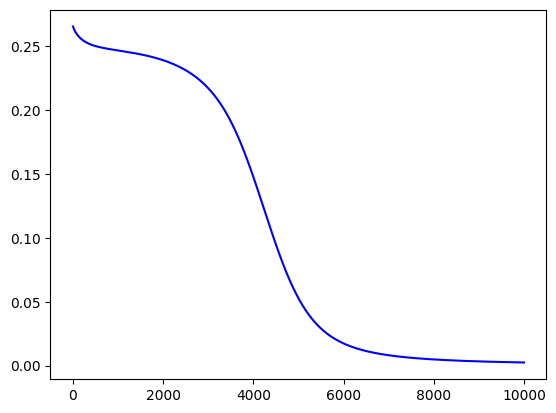

In [5]:
plt.plot(iterations, lossValues, color = 'b')
plt.show()

In [6]:
y_preds

[N950028 : (Value = 0.008948259235084383),
 N950047 : (Value = 0.9301407610643312),
 N950066 : (Value = 0.9301193943225565),
 N950085 : (Value = 0.01219420866514272)]

In [ ]:
draw_graph(mean_squared_error)